In [1]:
from trueskill import Rating, rate_1vs1, quality_1vs1, BETA
from trueskill.backends import cdf
import trueskill
from math import sqrt, pow
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use(['ggplot', 'grayscale'])
%matplotlib inline

trainingSet = "train_set.txt"
testSet = "test_set.txt"

players = {}

trainDF = pd.read_csv(trainingSet, header=None, sep="\t")
testDF = pd.read_csv(testSet, header=None, sep="\t")

# trainDF = trainDF.iloc[np.random.permutation(len(trainDF))]
# trainDF = trainDF.reset_index(drop=True)

In [3]:
trueskill.__version__

'0.4'

In [2]:
def win_probability(rA=Rating(), rB=Rating()):
    deltaMu = rA.mu - rB.mu
    sumSigma = rA.sigma ** 2 + rB.sigma ** 2
    playerCount = 2
    denominator = sqrt(playerCount * (BETA * BETA) + sumSigma)
    return cdf(deltaMu / denominator)

In [3]:
def experiment(env=trueskill.TrueSkill(draw_probability=0.0)):
    for name in pd.concat([trainDF[0], trainDF[1], testDF[0], testDF[1]]).unique():
        players[name] = env.create_rating()

    for row in trainDF.itertuples():
        i, winner, loser  = row
        players[winner], players[loser] = rate_1vs1(players[winner], players[loser], env=env)

    rows = []
    for row in testDF.itertuples():
        i, p1, p2, actual  = row
        pred = win_probability(players[p1], players[p2])
        rows.append([p1, p2, 1-pred, actual])
    rows = pd.DataFrame(rows, columns=['a', 'b', 'solve_prob', 'actual'])

    return rows

In [4]:
def score(df, eps=1e-19):
    return -np.mean(np.log(np.abs(df['solve_prob'] - df['actual']).clip(eps, 1-eps)))
def mae(df):
    return np.mean(np.abs(df['solve_prob'] - df['actual']))
def rmse(df):
    return np.sqrt(np.mean((df['solve_prob']-df['actual'])**2))
def crossentropy(df):
    return -np.mean(df['actual'] * np.log(df['solve_prob']) + (1-df['actual']) * (1-np.log(df['solve_prob'])))

In [5]:
def hc_acc_rmse(df, adqs=None):
    reshptest = pd.read_csv("res.hp.test.txt", sep="\t", header=None)
    reshptest.columns = ["pid", "handle", "solved", "contest", "level"]
    reshptest['solve_prob'] = df['solve_prob']
    reshptest.set_index(['contest', 'handle'])

    adqs = []
    for (contest, handle), rows in reshptest.groupby(['contest', 'handle']):
        cum = 1
        adq_probs = []
        for i, pid, handle, solved, contest, level, solve_prob in rows[::-1].itertuples():
            adq_probs.append(cum * solve_prob)
            cum = cum * (1-solve_prob)
        adq_probs.append(cum)
        adq = np.argmax(adq_probs[::-1])
        adqs.append((contest,handle,adq))
    adqs = pd.DataFrame(adqs)
    adqs.columns = ["contest", "handle", "pred"]

    hc_test_actual = pd.read_csv("res.hc.test.txt", header=None, sep="\t")
    hc_test_actual.columns = ["handle", "contest", "actual"]
    
    merged = adqs.merge(hc_test_actual, left_on=("contest", "handle"), right_on=("contest", "handle"))
    
    return (merged['actual'] == merged['pred']).mean(), np.sqrt(((merged['actual'] - merged['pred'])**2).mean())


In [6]:
# mu = 25.0
# sigma = mu / 3.0
# beta = sigma / 0.5
# tau = sigma / 100
# model = experiment(trueskill.TrueSkill(mu=mu, sigma=sigma, beta=beta, tau=tau))
model = experiment()

In [16]:
model.head()

a      b  solve_prob  actual
0  101_A  Alias    0.996193       1
1  101_B  Alias    0.682612       1
2  101_C  Alias    0.262490       1
3  101_D  Alias    0.075249       0
4  101_E  Alias    0.015137       0

# Trueskill 0.4.4

In [7]:
# Trueskill 0.4.4
"""
3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)
"""
print score(model)
print mae(model)
print rmse(model)
print crossentropy(model)
print hc_acc_rmse(model)

3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)


In [7]:
# trueskill 0.4
"""
3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)
"""
print score(model)
print mae(model)
print rmse(model)
print crossentropy(model)
print hc_acc_rmse(model)

3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)


In [7]:
# trueskill 0.2
"""
3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)
"""
print score(model)
print mae(model)
print rmse(model)
print crossentropy(model)
print hc_acc_rmse(model)

3.14182699133
0.205342760137
0.326424958383
-3.01832813703
(0.47316538882803943, 1.1224744480187112)


In [11]:
trueskill.

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=10.0%)

# Parameter Tuning

In [13]:
# Don't initialize it, if you want to cumulate the result for param tuning
param_model = {}

In [14]:
for bd in [1.2, 1.4, 1.6, 1.8]:
    for td in [1e4, 1e5, 1e6, 1e7]:
        if (bd,td) in param_model:
            continue
        mu = 25.0
        sigma = mu / 3.0
        beta = sigma / bd
        tau = sigma / td
        model = experiment(trueskill.TrueSkill(mu=mu, sigma=sigma, beta=beta, tau=tau, draw_probability=0))
        param_model[(bd,td)] = model
        print ((bd,td), rmse(model)) 

((1.2, 10000.0), 0.33143365859799617)
((1.2, 100000.0), 0.33143366539749564)
((1.2, 1000000.0), 0.33143366546553582)
((1.2, 10000000.0), 0.33143366546621633)
((1.4, 10000.0), 0.3289348445675549)
((1.4, 100000.0), 0.32893484644530918)
((1.4, 1000000.0), 0.32893484646415644)
((1.4, 10000000.0), 0.32893484646434562)
((1.6, 10000.0), 0.32730902947153101)
((1.6, 100000.0), 0.32730902485862046)


KeyboardInterrupt: 

In [15]:
pic = []
for (bd,td) in param_model:
    hp_score  = score(param_model[(bd,td)])
    hp_mae  = mae(param_model[(bd,td)])
    hp_rmse = rmse(param_model[(bd,td)])
    hp_ce = crossentropy(param_model[(bd,td)])
    hc_acc, hc_rmse = hc_acc_rmse(param_model[(bd,td)])

    pic.append((bd, td, hp_score, hp_mae, hp_rmse, hp_ce, hc_acc, hc_rmse))

pic = pd.DataFrame(pic)

/home/nicola/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


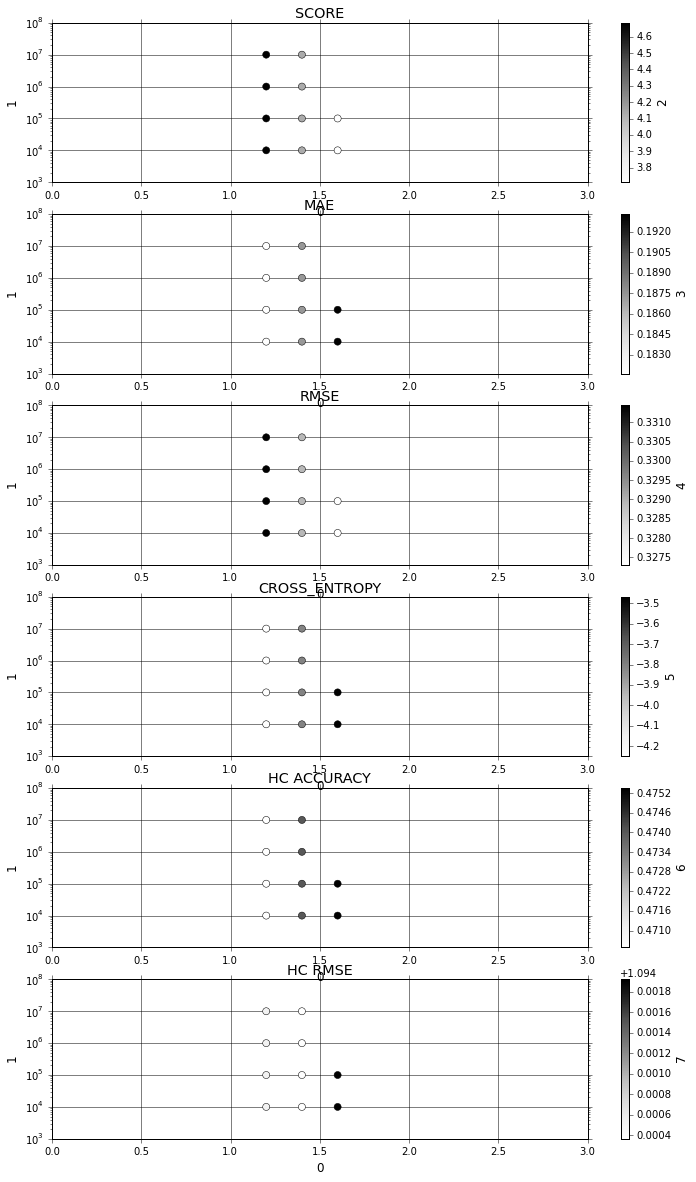

In [16]:
# SCORE: 2
# MAE: 3
# RMSE: 4
# CROSS_ENTROPY: 5
# HC ACCURACY: 6
# HC RMSE: 7

pic_cut = pic
# pic_cut = pic_cut[pic_cut[6] > .47]
# pic_cut = pic_cut[pic_cut[7] < 1.1]
# pic_cut[6] = pic_cut[6].clip(0.47,1)
# pic_cut[7] = pic_cut[7].clip(0,1.09)

f, axes = plt.subplots(6)
for i in range(6):
    pic_cut.plot.scatter(x=0,y=1,c=(i+2),s=50, figsize=(12, 20), title=["SCORE", "MAE", "RMSE", "CROSS_ENTROPY", "HC ACCURACY", "HC RMSE"][i], ax=axes[i],logy=True, xlim=(0,3))

In [285]:
m = param_model[(1.4, 1e3)]
m.loc()[np.argsort(np.abs(m['solve_prob'] - m['actual']))[::-1]]

a                      b    solve_prob  actual
5490   145_A          Dmitry_Egorov  9.999999e-01       0
435    103_A               ikatanic  9.999990e-01       0
784    107_E               xiaowuc1  6.685029e-06       1
28404  372_E                 permin  1.265843e-05       1
38956   77_B                tourist  9.999859e-01       0
3999   132_E             K_operafan  1.859919e-05       1
33266  407_A                 rng_58  9.999783e-01       0
34533  418_D                 laoriu  2.305424e-05       1
37445  446_A                   Petr  9.999767e-01       0
4603   135_D               johnLate  2.694948e-05       1
14330  264_A          ivan.metelsky  9.999729e-01       0
27130  367_A                Breakun  9.999619e-01       0
27560  367_A            marek.cygan  9.999502e-01       0
289    103_E                 MBabin  6.060030e-05       1
39035   83_A                 Komaki  9.999384e-01       0
4150   132_A                 guille  9.999329e-01       0
40395   91_B              liympanda  9.999299e-01       0
740    107_A                sankear  9.999151e-01       0
21568  333_C                  KungA  8.666590e-05       1
18590  288_A                  pperm  9.999050e-01       0
7500   191_A             Fefer_Ivan  9.998740e-01       0
18455  288_A           homo_sapiens  9.998690e-01       0
17825  286_A               huzecong  9.998449e-01       0
33540  414_B             Mithril0rd  9.998383e-01       0
12490  251_A                 darknp  9.998147e-01       0
22017  338_C               11115456  2.063240e-04       1
5255   142_A                  al13n  9.997856e-01       0
26420  360_A          niyaznigmatul  9.997847e-01       0
26755  364_A                  al13n  9.997610e-01       0
5525   145_A                 Monmoy  9.997400e-01       0
...      ...                    ...           ...     ...
30854  388_E                 Allex4  8.105907e-09       0
30939  388_E                Ibragim  7.876329e-09       0
13704  261_E                    MMJ  7.768482e-09       0
31764  403_E                 Reza_H  7.675510e-09       0
12739  256_D                   Bega  7.079246e-09       0
31514  388_E                stostap  6.756156e-09       0
21400  329_A                tourist  1.000000e+00       1
25574  356_E  Bistrigova_Anastasiya  6.046539e-09       0
16309  274_E                urahara  5.991175e-09       0
26773  364_D             c0d3junki3  5.811210e-09       0
36739  442_E          yoones.rezaei  5.442508e-09       0
16839  283_E                   Bega  5.329555e-09       0
28499  372_E                urahara  5.099475e-09       0
24951  354_D       Bekzhan.Kassenov  4.523536e-09       0
20090  319_A                   Petr  1.000000e+00       1
30859  388_E               Amirnasr  4.300027e-09       0
28149  372_E             cup_of_tea  4.147316e-09       0
26774  364_E             c0d3junki3  3.740170e-09       0
1185   109_A                   sdya  1.000000e+00       1
25346  354_D                  kco_c  2.083871e-09       0
32979  407_E                 Reza_H  2.072415e-09       0
31244  388_E               bigbrain  1.878875e-09       0
32934  407_E    LashaBukhnikashvili  1.538788e-09       0
2240   115_A                   Petr  1.000000e+00       1
14584  269_E       Bekzhan.Kassenov  1.369975e-09       0
37349  446_E                Kiryuha  1.061417e-09       0
1050   109_A             dzhulgakov  1.000000e+00       1
31254  388_E             c0d3junki3  5.610078e-10       0
2550   115_A                tourist  1.000000e+00       1
1220   109_A                tourist  1.000000e+00       1

[41085 rows x 4 columns]

In [301]:
model.head(20)

a        b    solve_prob  actual
0   101_A    Alias  9.999923e-01       1
1   101_B    Alias  5.372282e-01       1
2   101_C    Alias  8.824241e-03       1
3   101_D    Alias  1.744933e-05       0
4   101_E    Alias  6.442600e-08       0
5   101_A  Alireza  9.997641e-01       1
6   101_B  Alireza  2.012649e-01       0
7   101_C  Alireza  4.062805e-04       0
8   101_D  Alireza  1.412410e-07       0
9   101_E  Alireza  1.674855e-10       0
10  101_A  ArchMaG  9.994449e-01       1
11  101_B  ArchMaG  4.737336e-01       0
12  101_C  ArchMaG  2.341535e-02       0
13  101_D  ArchMaG  3.631187e-04       0
14  101_E  ArchMaG  8.715187e-06       0
15  101_A   Cepera  9.999997e-01       1
16  101_B   Cepera  8.254023e-01       1
17  101_C   Cepera  7.386896e-02       1
18  101_D   Cepera  7.732141e-04       0
19  101_E   Cepera  9.146689e-06       0

In [299]:
param_model[(0.5, 100)]

a               b    solve_prob  actual
0      101_A           Alias  9.999996e-01       1
1      101_B           Alias  7.948509e-01       1
2      101_C           Alias  5.575133e-02       1
3      101_D           Alias  1.876034e-04       0
4      101_E           Alias  1.679924e-06       0
5      101_A         Alireza  9.999829e-01       1
6      101_B         Alireza  4.578974e-01       0
7      101_C         Alireza  5.062448e-03       0
8      101_D         Alireza  2.478372e-06       0
9      101_E         Alireza  7.518410e-09       0
10     101_A         ArchMaG  9.995098e-01       1
11     101_B         ArchMaG  5.113826e-01       0
12     101_C         ArchMaG  3.197987e-02       0
13     101_D         ArchMaG  3.443755e-04       0
14     101_E         ArchMaG  9.953915e-06       0
15     101_A          Cepera  1.000000e+00       1
16     101_B          Cepera  9.287363e-01       1
17     101_C          Cepera  1.875208e-01       1
18     101_D          Cepera  2.468246e-03       0
19     101_E          Cepera  5.051487e-05       0
20     101_A        Chubcheg  9.998748e-01       1
21     101_B        Chubcheg  4.212580e-01       1
22     101_C        Chubcheg  7.564874e-03       0
23     101_D        Chubcheg  1.103367e-05       0
24     101_E        Chubcheg  7.609560e-08       0
25     101_A            Erop  1.000000e+00       1
26     101_B            Erop  9.276182e-01       1
27     101_C            Erop  1.860047e-01       1
28     101_D            Erop  2.440735e-03       0
29     101_E            Erop  4.999393e-05       0
...      ...             ...           ...     ...
41055   95_A  wRabbits_AlMag  9.364238e-01       1
41056   95_C  wRabbits_AlMag  2.907215e-01       0
41057   95_B  wRabbits_AlMag  3.126075e-02       0
41058   95_E  wRabbits_AlMag  4.444453e-08       0
41059   95_D  wRabbits_AlMag  1.069474e-09       0
41060   95_A     wangjunyong  9.100009e-01       0
41061   95_C     wangjunyong  4.595820e-01       0
41062   95_B     wangjunyong  1.556502e-01       0
41063   95_E     wangjunyong  2.530850e-04       0
41064   95_D     wangjunyong  3.967496e-05       0
41065   95_A          whhone  9.688880e-01       0
41066   95_C          whhone  4.574524e-01       1
41067   95_B          whhone  8.799746e-02       0
41068   95_E          whhone  1.413469e-06       0
41069   95_D          whhone  5.816177e-08       0
41070   95_A    winterwolf94  7.792977e-01       1
41071   95_C    winterwolf94  1.375356e-01       0
41072   95_B    winterwolf94  1.176445e-02       1
41073   95_E    winterwolf94  3.424923e-08       0
41074   95_D    winterwolf94  1.155151e-09       0
41075   95_A           x-ray  8.566886e-01       0
41076   95_C           x-ray  2.599102e-01       1
41077   95_B           x-ray  4.251728e-02       1
41078   95_E           x-ray  1.946569e-06       0
41079   95_D           x-ray  1.242232e-07       0
41080   95_A          zzldjk  7.601858e-01       1
41081   95_C          zzldjk  1.450931e-01       1
41082   95_B          zzldjk  1.499848e-02       0
41083   95_E          zzldjk  1.327502e-07       0
41084   95_D          zzldjk  5.975243e-09       0

[41085 rows x 4 columns]

In [304]:
mae(param_model[(1.4,1e3)])

0.18330756577364493